# Stratified cross-validation for unbiased and privacy-preserving federated learning

In this notebook we study cross-validation of a model when data is distributed in many data warehouses and is analyzed using federated learning. We consider in particular the recurrent problem related to the presence of duplicates of individuals' records. These duplicates are difficult to detect and to clean in a federated learning setting inducing possible data leakage between training and validation datasets that causes over-optimistic estimates of performances. 

Hereafter we generate synthetic datasets with duplicates and fit XGBoost models on them. Our datasets are made of records $(\mathbf{x}, y)$ with $\mathbf{x} = (x_1, x_2, ..., x_{10})$ real covariates and $y\in\{0,1\}$ a binary output. We consider the training of a model $f$ that computes a predicted output $\tilde{y}=f(\mathbf{x})$. We consider as performance metric the accuracy $Accuracy = \mathbb{E}I(y=\tilde{y})$ with $I(A)$ a function that is equal to 1 when $A$ is true and 0 otherwise.

We measure training and validation performances using cross-validation. In the absence of duplicates, partitioning randomly the dataset in folds and applying cross-validation on these folds provides *unbiased estimates* of accuracy. In the presence of duplicates we consider *stratified cross-validation* that consists in partitioning the dataset in folds containing individuals that share similar values of a stratifying covariate $x_{str}$ and in applying cross-validation on these folds. *Stratified cross-validation* avoids over-optimistic biases due to data leakage, but may cause pessimistic biases due to inter-fold heterogeneities. As shown in these simulations, a judicious choice of stratification strategy limits this pessimistic bias and provides a validation methodology that is well suited to federated learning setting.

## Libraries

In [1]:
import numpy as np
import math
import scipy
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Seed the random generator
np.random.seed(123)

# Dataset generators
We define functions that will be used to generate datasets of various sizes, amounts of duplicates and that can be partitioned in folds adopting different dataset partitioning strategies.

Each covariate vector is generated through a centered normal distribution of mean $[\mu_1, \mu_2, ..., \mu_{10}]=[0, 0, ..., 0]$ and of covariance matrix $\Sigma$:

$$
\left[\begin{array}{c} x_1 \\ x_2 \\ ... \\ x_{10} \end{array}\right]= \mathcal{N}\left(\left[\begin{array}{c} \mu_1 \\ \mu_2 \\ ... \\ \mu_{10} \end{array}\right], \Sigma \right)
$$

The covariance matrix $\Sigma$ is generated as to obtain 9 correlated covariates $x_1$, $x_2$,...$x_9$ and an independent covariate $x_{10}$. For each covariate vector we generate randomly an outcome $y$ through a logistic model that reproduces a highly non-linear association:

$$
\log\frac{p\big(y=1 | x_1,..., x_{10}\big)}{p\big(y=0 | x_1,..., x_{10}\big)}= a_0 +a_1 x_1 +a_2 x_2 + a_3 x_3 + a_{4}x_1 x_2 + a_{5}x_3I(x_4>0) + a_{6}x_5^2 I(x_6>0) + a_7 x_7 I(x_8 x_9>0)
$$


#### Raw data generator
Generator of a dataset without duplicates

In [2]:
def f_indic(x):
    res = 0
    if x>0:
        res = 1
    return res

def f_model(x_vec, a_vec):
    res = a_vec[0] + a_vec[1]*x_vec[0] + a_vec[2]*x_vec[1] + a_vec[3]*x_vec[2] \
        + a_vec[4]*x_vec[0]*x_vec[1] + a_vec[5]*x_vec[2]*f_indic(x_vec[3]) + a_vec[6]*x_vec[4]**2*f_indic(x_vec[5]) \
        + a_vec[7]*x_vec[6]*f_indic(x_vec[7]*x_vec[8])
    return res

def logistic_f(x):
    res = 1/(1+np.exp(-x))
    return res

def prob_outcome(x_vec, a_vec):
        """
        Probability of an outcome y=1 given a covariate vector x_vec
        and a parameter vector a_vec
        """
        res = f_model(x_vec, a_vec)
        res = logistic_f(res)
        return res
    
def raw_data_generator(param_data):
    """
    Function that simulates a dataset without duplicates
    Each record is randomly associated with one of the hospitals, with
    equal probablity.
    
    Inputs:
    - param_data: dictionnary of parameters defining the data generation

    Outputs:
    - x_arr: array of covariates (row: records, column: covariates)
    - y_arr: array of outcomes
    - h_arr: array of hospital indexes
    """
    # Number of patients
    num_pat = param_data['num_pat']
    
    # Number of hospitals
    num_h = param_data['num_h']
    
    # Data generation parameters
    a_vec = param_data['a_vec']
    sigma = param_data['sigma']
    
    # Mean of the normal distribution used to generate covariates:
    mean = np.zeros(10)
    
    # Each patient is assigned randomly to an hospital
    h_arr = np.random.rand(num_pat)
    h_arr = np.floor(h_arr*num_h)
    h_arr = h_arr.astype(int)
        
    # Random generation of covariates
    x_arr = np.random.multivariate_normal(mean, sigma, num_pat)

    # Random generation of outcomes
    func_prob = lambda x_vec : prob_outcome(x_vec, a_vec)
    prob = np.apply_along_axis(func_prob, 1, x_arr)
    rand_m = np.random.rand(num_pat)
    condition = rand_m<prob
    y_arr = np.where(condition,1,0).astype(int)
        
    return x_arr, y_arr, h_arr

#### Duplicates generator
A function that adds duplicates to a dataset

In [3]:
def duplicates_generator(param_data, x_arr, y_arr, h_arr):
    """
    Function that completes a data array with duplicates
    
    Inputs:
    - param_data: dictionary of parameters defining the data generation
    - x_arr: array of covariates (row: record, column: covariates)
    - y_arr: array of outcomes
    - h_arr: array of hospital indexes
    
    Outputs:
    - x_arr: array of covariates (row: records, column: covariates) with duplicates
    - y_arr: array of outcomes with duplicates
    - h_arr: array of hospital indexes with duplicates
    """
    # Number of patients
    num_pat = param_data['num_pat']
    
    # Number of duplicated records
    num_dup = param_data['num_dup']
    
    # Number of hospitals
    num_h = param_data['num_h']
    
    assert y_arr.shape[0] == num_pat, "Wrong outcome array {}"
    assert h_arr.shape[0] == num_pat, "Wrong hospital array"
    
    # Create an array used to ensure that two duplicates are never in the same 
    # hospital
    control_duplicates = np.zeros((num_pat, num_h), dtype=int)
    for id_pat in range(num_pat):
        id_h = h_arr[id_pat]
        control_duplicates[id_pat, id_h] = 1
    def is_patient_in_h(id_pat, id_h):
        return control_duplicates[id_pat, id_h] == 1
    
    # Add duplicates
    count_dup = 0
    x_arr_dup = np.zeros((num_dup, x_arr.shape[1]), dtype=float)
    h_arr_dup = np.zeros(num_dup, dtype=int)
    y_arr_dup = np.zeros(num_dup, dtype=int)
    while count_dup < num_dup:
        # Draw an existing record at random
        randnum = np.random.rand()
        id_pat = int(np.floor(randnum * num_pat))
        assert id_pat < num_pat
        
        # Draw randomly a hospital in which to duplicate the record
        randnum = np.random.rand()
        id_h = int(np.floor(randnum * num_h))
        assert id_h < num_h
        
        # Control that a duplicate of this record does not already exist in
        # the given hospital
        if not is_patient_in_h(id_pat, id_h):
            x_arr_dup[count_dup, :] = x_arr[id_pat, :]            
            y_arr_dup[count_dup] = y_arr[id_pat]
            h_arr_dup[count_dup] = id_h
            count_dup += 1
    
    # Add duplicates to existing datasets
    x_arr_res = np.concatenate((x_arr, x_arr_dup))
    y_arr_res = np.concatenate((y_arr, y_arr_dup))
    h_arr_res = np.concatenate((h_arr, h_arr_dup))
            
    return x_arr_res, y_arr_res, h_arr_res

#### Random/stratified splitting of records in folds
Functions that split a dataset in folds using either the *random* or the *stratified* fold-partitioning strategy 

In [4]:
def random_splitting(param_data, param_split, x_arr, y_arr, h_arr):
    """
    Function that splits randomly the records in folds of equal size (per
    hospital)
    
    Inputs:
    - param_data: dictionary of parameters defining the data generation
    - param_split: dictionary of parameters defining the data splitting
    - x_arr: array of covariates (row: record, column: covariates)
    - y_arr: array of outcomes 
    - h_arr: array of hospital indexes
    
    Outputs:
    - f_arr: array of fold indexes
    """
    # Number of patients
    num_pat = param_data['num_pat']
    
    # Number of duplicated records
    num_dup = param_data['num_dup']
    
    # Number of hospitals
    num_h = param_data['num_h']
    
    # Number of folds
    num_f = param_split['num_f']
    
    # Array containing the fold index of each record
    f_arr = np.zeros(num_pat + num_dup, dtype=int)
    assert f_arr.shape[0] == x_arr.shape[0], "Wrong f_arr shape"
    
    # Count the number of records per hospital
    num_rec = num_pat + num_dup
    count_h = np.zeros(num_h, dtype=int)
    for id_rec in range(num_rec):
        id_h = h_arr[id_rec]
        count_h[id_h] += 1
    
    # Compute the number of records that each fold will
    # contain, splitting each hospital dataset in equally sized folds
    num_rec_f = np.zeros((num_h, num_f), dtype=int)
    for id_h in range(num_h):
        num_rec_h = count_h[id_h]
        
        # Each folds contains at least the quotient of the 
        # euclidian division of the number of records by
        # the number of folds
        quotient = int(np.floor(num_rec_h / num_f))
        num_rec_f[id_h, :] = quotient
        rem_n = num_rec_h - quotient * num_f
        assert rem_n < num_f, "Problem during fold splitting"

        # Distribute randomly the remaining records among the hospitals
        count_rem_f = np.zeros(num_f, dtype=int)
        while rem_n > 0:
            randnum = np.random.rand()
            id_f = int(np.floor(randnum * num_f))
            assert id_f < num_f
            
            if count_rem_f[id_f] == 0:
                num_rec_f[id_h, id_f] += 1
                rem_n -= 1
                count_rem_f[id_f] += 1
            
    # Randomly assign each record to a fold in such a way that it
    # fulfills the required number of records per fold per hospital
    
    # Create an array that stores the amount of records assigned to
    # each fold, and create a function to test whether a fold
    # is full or not
    count_rec_f = np.zeros((num_h, num_f), dtype=int)
    def is_fold_full(id_h, id_f):
        return count_rec_f[id_h, id_f]==num_rec_f[id_h, id_f]
    
    # Assign each record randomly to a fold that is not full
    for id_rec in range(num_rec):
        id_h = h_arr[id_rec]
        
        assigned = False
        while not assigned:
            randnum = np.random.rand()
            id_f = int(np.floor(randnum * num_f))
            if not is_fold_full(id_h, id_f):
                f_arr[id_rec] = id_f
                count_rec_f[id_h, id_f] += 1
                assigned = True
                
    return f_arr


def stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr):
    """
    Function that splits the records in folds stratifying 
    along a covariate
    
    Inputs:
    - param_data: dictionary of parameters defining the data generation
    - param_split: dictionary of of parameters defining the data splitting
    - x_arr: array of covariates (row: record, column: covariates)
    - y_arr: array of outcomes for each record
    - h_arr: array of hospital index for each record

    Outputs:
    - f_arr: empty array of fold indexes
    """
    # Number of patients
    num_pat = param_data['num_pat']
    
    # Number of duplicated records
    num_dup = param_data['num_dup']
    
    # Number of hospitals
    num_h = param_data['num_h']
    
    # Number of folds
    num_f = param_split['num_f']
    
    # Index of the fold used for validation
    id_str = param_split['stratifying_covariate_id']
    
    # Total number of records
    num_rec = num_pat + num_dup
    
    # Array containing the fold index of each record
    f_arr = np.zeros(num_pat + num_dup, dtype=int)
    assert f_arr.shape[0] == x_arr.shape[0]
    
    # Array containing all the values of the stratifying covariate
    str_arr = x_arr[:, id_str]
        
    # Sorting of the stratifying covariates
    str_arr = np.sort(str_arr)
    
    # Computing the size of each global fold
    fold_size = np.zeros(num_f, dtype=int)
    quotient = int(np.floor(num_rec / num_f))
    fold_size[:] = quotient
    rem_n = num_rec - quotient * num_f
    assert rem_n < num_f

    count_rem_f = np.zeros(num_f, dtype=int)
    while rem_n > 0:
        randnum = np.random.rand()
        id_f = int(np.floor(randnum * num_f))
        assert id_f < num_f

        if count_rem_f[id_f] == 0:
            fold_size[id_f] += 1
            rem_n -= 1
            count_rem_f[id_f] += 1
    
    # Compute the thresholds t for stratification such that each global 
    # fold contains approximately the same number of records
    thresh_arr = np.zeros(num_f - 1, dtype=float)
    fold_count = 0
    for id_lim in range(num_f - 1):
        fold_count += fold_size[id_lim]
        
        # Lower limit required for the threshold
        val_low = str_arr[fold_count-1]
        
        # Upper limit required for the threshold
        val_up = str_arr[fold_count]
        
        # Threshold definition as the intermediate value
        thresh_arr[id_lim] = 0.5*(val_low + val_up)
        
    # Assign each record to a fold depending on the value of its 
    # stratifying covariate
    for id_rec in range(num_rec):
        # Record's stratifying covariate
        cov_str = x_arr[id_rec, id_str]
        
        # Find the threshold index that corresponds to the record
        # and assign the record to the corresponding fold
        for count_f in range(num_f-1):
            thresh = thresh_arr[count_f]
            if cov_str < thresh:
                f_arr[id_rec] = count_f
                break
            
            # If the record has not been assigned to the first num_f-1
            # folds, assign it to the last fold
            if count_f == num_f-2:
                f_arr[id_rec] = count_f+1
            
    return f_arr

#### Training / validation dataset creation for a given fold index
A function that splits a dataset in training and validation subsets

In [5]:
def train_val_building(param_data, param_split, x_arr, y_arr, f_arr, id_val_fold):
    """
    Function that builds training and validation datasets out of a dataset
    that is already split in folds
    
    Inputs:
    - param_data: dictionary of parameters defining the data generation
    - param_split: dictionary of parameters defining the data splitting
    - x_arr: array of covariates (row: record, column: covariates)
    - y_arr: array of outcomes
    - f_arr: array of fold indexes
    - id_val_fold: index of the fold used for validation
    
    Outputs:
    - x_train
    - y_train
    - x_val
    - y_val
    """
    # Number of patients
    num_pat = param_data['num_pat']
    
    # Number of duplicated records
    num_dup = param_data['num_dup']
    
    # Number of folds
    num_f = param_split['num_f']
    
    # Number of records
    num_rec = num_pat + num_dup
    
    # Number of training and validation records
    num_train = np.count_nonzero(f_arr!=id_val_fold)
    num_val = np.count_nonzero(f_arr==id_val_fold)
    assert num_train+num_val==num_rec, "prob train val split"
            
    # Create training and validation numpy arrays
    val_boolean_mask = f_arr == id_val_fold
    x_val = x_arr[val_boolean_mask,:]
    y_val = y_arr[val_boolean_mask]
    train_boolean_mask = f_arr != id_val_fold
    x_train = x_arr[train_boolean_mask,:]
    y_train = y_arr[train_boolean_mask]
    assert x_train.shape[0]+x_val.shape[0]==num_rec, "prob train val split"
    assert y_train.shape[0]+y_val.shape[0]==num_rec, "prob train val split"
    
    # Shuffle arrays
    permutation = np.random.permutation(num_train)
    x_train = x_train[permutation, :]
    y_train = y_train[permutation]
    permutation = np.random.permutation(num_val)
    x_val = x_val[permutation, :]
    y_val = y_val[permutation]

    return x_train, y_train, x_val, y_val

## Gradient Boosting fitting
A function that fits a gradient boosting model to a dataset

In [6]:
def GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model):
    """
    A function that fits a XGBoost model using cross validation on a dataset
    that has already been partitioned in folds
    
    Inputs:
    - param_data: dictionary of parameters defining the data generation
    - param_split: dictionary of parameters defining the data splitting
    - x_arr: array of covariates (row: record, column: covariates)
    - y_arr: array of outcomes
    - f_arr: array of fold indexes
    
    Outputs:
    - train_acc_list: list of training accuracies computed for each fold
    - val_acc_list: list of validation accuracies computed for each fold
    - feature_importance_list: list of feature importance computed for each fold
    """
    # Number of folds
    num_f = param_split['num_f']
    
    # Number of boosting iterations
    n_round = param_model['num_round']
    
    # Train accuray list
    train_acc_list = []
    
    # Validation accuracy list
    val_acc_list = []
    
    # Feature importance list
    feature_importance_list = []
    
    # Successive training and validation on each one of the num_f folds
    for id_f in range(num_f):
        x_train, y_train, x_val, y_val = train_val_building(param_data, param_split, x_arr, y_arr, f_arr, id_f)

        dM_train = xgb.DMatrix(x_train, label=y_train)
        dM_val = xgb.DMatrix(x_val, label=y_val)

        evallist = [(dM_val, 'val'), (dM_train, 'train')]

        monitoring = dict()
        bst = xgb.train(param_model, dM_train, n_round, evallist, evals_result = monitoring, verbose_eval=False)

        if param_model['eval_metric']=='error':
            train_err = monitoring['train']['error']
            val_err = monitoring['val']['error']
            
            # Transform error in accuracy
            train_acc = 1-np.asarray(train_err)
            val_acc = 1-np.asarray(val_err)
            
            # Add per-fold results to global list
            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)
        elif param_model['eval_metric']=='auc':
            train_auc = monitoring['train']['auc']
            val_auc = monitoring['val']['auc']
            
            # Add per-fold results to global list
            train_acc_list.append(train_auc)
            val_acc_list.append(val_auc)

        # Extract each feature importance
        feat_imp = bst.get_score(importance_type='gain')
        feature_importance_list.append(feat_imp)
        
            
    return train_acc_list, val_acc_list, feature_importance_list

## Preliminary tests
Before running large-scale simulation we test that our experiment-generating functions work on some specific examples

### Initial data exploration

#### Data visualization

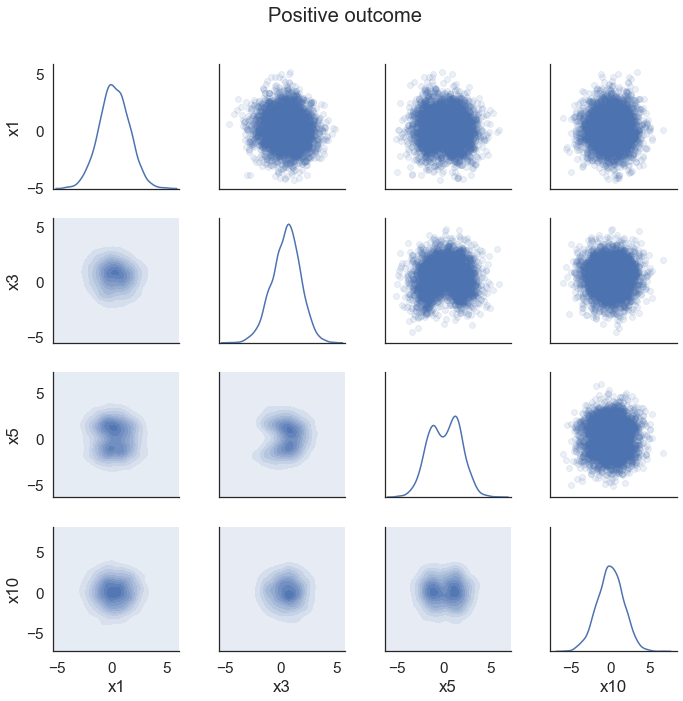

In [7]:
## Parameters for data generation
a_vec = [-2, 0.4, 0.8, 1.2, 0.4, 1.2,3.0,2.0]
## Eigenvalues of the covariance matrix
lambda_vec = [1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6]
lambda_10 = 2.8
## Random orthogonal matrix
O = scipy.stats.ortho_group.rvs(9)
## Covariance matrix
sigma_prime = np.dot(O, np.dot(np.diag(lambda_vec), np.transpose(O)))
sigma = scipy.linalg.block_diag(sigma_prime, lambda_10)
## Number of patients
num_pat = 10000
## Number of duplicates
num_dup = 0
## Number of hospitals
num_h = 1

param_data = {'num_pat':num_pat, 'num_dup':num_dup, 'num_h':num_h, 'a_vec':a_vec, 'sigma':sigma}

# Raw data generation
x_arr, y_arr, _ = raw_data_generator(param_data)

# function measuring the probability of a positive outcome
func_prob_loc = lambda x_vec : prob_outcome(x_vec, a_vec)

# Vector containing the probability of a positive outcome for each record
p1_arr = np.apply_along_axis(func_prob_loc, 1, x_arr)

# Vector containing the optimal prediction to maximize the accuracy
pred_opt = p1_arr>0.5
pred_opt = pred_opt.reshape((num_pat,1))

tot_arr = np.concatenate((x_arr, pred_opt), axis=1)

# Plotting of some of the dataset characteristics
df = pd.DataFrame(tot_arr, columns=["x1", "x2", "x3", "x4", \
                                    "x5", "x6", "x7", "x8", \
                                    "x9", "x10", "pred"])
df = df.astype({"pred": 'int32'})
sns.set(style="white", font_scale = 1.4)
df_positive = df.loc[df["pred"]==1]

g = sns.PairGrid(df_positive, x_vars=["x1","x3","x5","x10"],y_vars=["x1", "x3", "x5","x10"])
g.map_diag(sns.kdeplot)
g.map_upper(plt.scatter, alpha=0.1)

from matplotlib.colors import LogNorm
def pairgrid_heatmap(x, y, **kws):
    sns.kdeplot(x, y, shade=True, shade_lowest=True)

g.map_lower(pairgrid_heatmap)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Positive outcome")

plt.savefig('SF_Fig1.pdf', bbox_inches="tight")

#### Optimal accuracy

In [8]:
### Number of patients
num_pat = 1000000
### Number of duplicates
num_dup = 0
### Number of hospitals
num_h = 1

param_data = {'num_pat':num_pat, 'num_dup':num_dup, 'num_h':num_h, 'a_vec':a_vec, 'sigma':sigma}

x_arr, y_arr, _ = raw_data_generator(param_data)

# Probability of positive outcome measurement
p1_arr = np.apply_along_axis(func_prob_loc, 1, x_arr)
pred_opt = p1_arr>0.5

acc_opt = np.mean(pred_opt==y_arr)
print("Optimal accuracy: {}".format(acc_opt))

Optimal accuracy: 0.881395


### Test 1: random partitioning
We apply classical cross-validation to a dataset containing duplicates. Partitioning randomly the dataset in folds does not prevent data leakage, as duplicates of a given record can be present simultaneously in training and validation folds. The estimated validation performances are consequently over-optimistic.

Proportion of positive outcome: 0.46658333333333335
Maximal values of covariates: [5.48690759 4.78149299 5.66096344 6.06797576 5.05067452 4.87382256
 4.93824278 6.57789821 5.02249825 6.50422897]
Minimal values of covariates: [-4.81026034 -5.01434916 -4.56376838 -4.98768103 -5.69858378 -4.78032954
 -4.54054395 -5.7536598  -5.3236097  -6.70878709]


Text(0.5, 1.0, 'Over-optimistic validation (data leakage)')

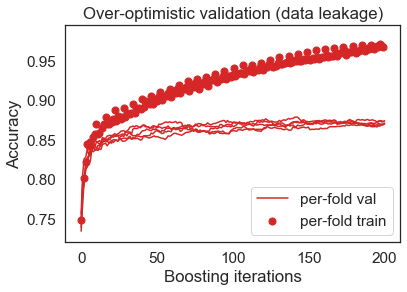

In [9]:
## Data generation
# Number of patients
num_pat = 10000
# Number of duplicates
num_dup = 2000
# Number of hospitals
num_h = 5
param_data = {'num_pat':num_pat, 'num_dup':num_dup, 'num_h':num_h, 'a_vec':a_vec, 'sigma':sigma}

## Data splitting
# Splitting strategy (stratified or random)
split_strat = 'random'
# Number of folds for cross validation
num_f = 5
# Stratigying covariate (only used for stratified cross validation)
stratifying_covariate_id = 9
param_split = {'split_strat':split_strat, 'num_f':num_f, 'stratifying_covariate_id':stratifying_covariate_id}

## Model fitting
fit_model = 'GB'
max_depth = 3
eta = 0.6
objective = 'binary:logistic'
eval_metric = 'error'
num_round = 200
param_model = {'fit_model':fit_model, 'max_depth':max_depth, 'eta':eta, 'objective':objective, 'eval_metric':eval_metric, 
              'num_round':num_round}

## Data characterization
# Raw data generation
x_arr, y_arr, h_arr = raw_data_generator(param_data)
# Insertion of duplicates
x_arr, y_arr, h_arr = duplicates_generator(param_data, x_arr, y_arr, h_arr)
# Print proportion of positive outcome
prop_outcome = np.sum(y_arr)/len(y_arr)
print("Proportion of positive outcome: {}".format(prop_outcome))

# Print maximal values
max_values = np.amax(x_arr, axis=0)
print("Maximal values of covariates: {}".format(max_values))

# Print minimal values
min_values = np.amin(x_arr, axis=0)
print("Minimal values of covariates: {}".format(min_values))

f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
# Number of training curves (correspond to each training on a subset during cross-validation)
num_curve = len(train_acc)
num_feat_importance = len(feat_imp)
epochs = len(train_acc[0])

x_plt = np.linspace(0, epochs, epochs)

for id_curve in range(num_curve):
    if id_curve==0:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, label='per-fold train', color='tab:red', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], label='per-fold val', color='tab:red')
    else:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, color='tab:red', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], color='tab:red')
plt.xlabel("Boosting iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Over-optimistic validation (data leakage)")

### Test 2: stratified partitioning, uncorrelated covariate
We run an experiment adopting the *stratified cross-validation* strategy, stratifying along the covariate that is an independent variable. Thus we prevent data leakage and we obtain folds that are statistically equivalent: the validation performances correspond to the desired unbiased internal validation.

Text(0.5, 1.0, 'Unbiased validation')

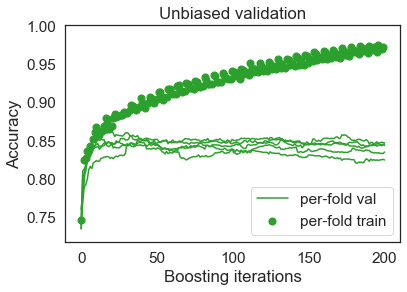

In [10]:
# Splitting strategy (stratified or random)
param_split['split_strat']='stratified'
# Stratifying covariate (for stratified cross validation)
stratifying_covariate_id = 9
param_split['stratifying_covariate_id']=stratifying_covariate_id

f_arr = stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
# Number of training curves (correspond to each training on a subset during cross-validation)
num_curve = len(train_acc)
num_feat_importance = len(feat_imp)
epochs = len(train_acc[0])

x_plt = np.linspace(0, epochs, epochs)

for id_curve in range(num_curve):
    if id_curve==0:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, label='per-fold train', color='tab:green', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], label='per-fold val', color='tab:green')
    else:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, color='tab:green', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], color='tab:green')
plt.xlabel("Boosting iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Unbiased validation")

### Test 3: stratified partitioning, correlated covariate
We run an experiment adopting the *stratified cross-validation* strategy, stratifying along a covariate that is correlated to other covariates and to the outcome. We prevent data leakage and avoid thus over-optimistic validation, but the folds obtained after stratification are statistically heterogeneous, and estimated performances may be pessimistic.

Text(0.5, 1.0, 'Pessimistic validation (inter-fold heterogeneity)')

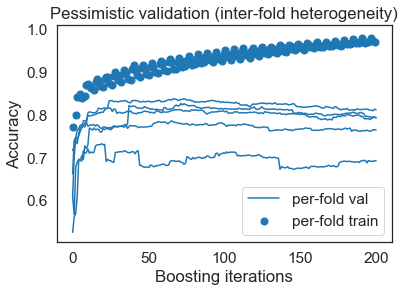

In [11]:
param_split['split_strat']='stratified'
stratifying_covariate_id = 4
param_split['stratifying_covariate_id']=stratifying_covariate_id

f_arr = stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
# Number of training curves (correspond to each training on a subset during cross-validation)
num_curve = len(train_acc)
num_feat_importance = len(feat_imp)
epochs = len(train_acc[0])

x_plt = np.linspace(0, epochs, epochs)

for id_curve in range(num_curve):
    if id_curve==0:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, label='per-fold train', color='tab:blue', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], label='per-fold val', color='tab:blue')
    else:
        x_scat = [x_plt[index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        y_scat = [train_acc[id_curve][index] for index in range(len(x_plt)) if (index+id_curve)%6==0]
        plt.scatter(x_scat, y_scat, color='tab:blue', marker='o', s=50)
        plt.plot(x_plt, val_acc[id_curve], color='tab:blue')
plt.xlabel("Boosting iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Pessimistic validation (inter-fold heterogeneity)")

# Large scale simulation
We run large scale simulations with various experimental conditions in order to probe the characteristics of cross-validation methodologt.

### Fig. 2: Monitoring of Gradient Boosting fitting
We run a single experiment to illustrate the variation of performances during boosting

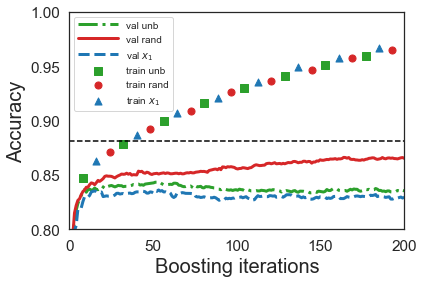

In [12]:
fig, ax = plt.subplots()
sns.set(style="white", font_scale = 1.4)

num_round = 200
param_model['num_round']=num_round
num_dup = 0
param_data['num_dup'] = num_dup
x_arr, y_arr, h_arr = raw_data_generator(param_data)

# Analysis without duplicates (unbiased)
split_strat = 'random'
param_split['split_strat'] = split_strat
f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
# Number of training curves (correspond to each training on a subset during cross-validation)
num_curve = len(train_acc)
num_feat_importance = len(feat_imp)
epochs = len(train_acc[0])
x_plt = np.linspace(0, epochs, epochs)

av_train_unbias_acc = np.zeros(epochs)
av_train_r_acc = np.zeros(epochs)
av_train_x_acc = np.zeros(epochs)

av_val_unbias_acc = np.zeros(epochs)
av_val_r_acc = np.zeros(epochs)
av_val_x_acc = np.zeros(epochs)

for id_curve in range(num_curve):
    av_train_unbias_acc += train_acc[id_curve]
    av_val_unbias_acc += val_acc[id_curve]

# Insertion of duplicates
num_dup = 2000
param_data['num_dup'] = num_dup
x_arr, y_arr, h_arr = duplicates_generator(param_data, x_arr, y_arr, h_arr)

# Analysis through random fold-partitioning
split_strat = 'random'
param_split['split_strat'] = split_strat
f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
for id_curve in range(num_curve):
    for id_epoch in range(epochs):
        av_train_r_acc[id_epoch] += train_acc[id_curve][id_epoch]
        av_val_r_acc[id_epoch] += val_acc[id_curve][id_epoch]

# Analysis through stratified fold-partitioning
split_strat = 'stratified'
param_split['split_strat'] = split_strat
stratifying_covariate_id = 0
param_split['stratifying_covariate_id'] = stratifying_covariate_id
f_arr = stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
for id_curve in range(num_curve):
    av_train_x_acc += train_acc[id_curve]
    av_val_x_acc += val_acc[id_curve]
        
av_train_unbias_acc /= num_curve  
av_train_r_acc /= num_curve
av_train_x_acc /= num_curve

av_val_unbias_acc /= num_curve
av_val_r_acc /= num_curve
av_val_x_acc /= num_curve

x_unbias_m = [x_plt[index] for index in range(len(x_plt)) if (index+16)%24==0]
train_unbias_m = [av_train_unbias_acc[index] for index in range(len(x_plt)) if (index+16)%24==0]
x_r_m = [x_plt[index] for index in range(len(x_plt)) if index%24==0]
train_r_m = [av_train_r_acc[index] for index in range(len(x_plt)) if index%24==0]
x_x_m = [x_plt[index] for index in range(len(x_plt)) if (index+8)%24==0]
train_x_m = [av_train_x_acc[index] for index in range(len(x_plt)) if (index+8)%24==0]

s1 = plt.scatter(x_unbias_m, train_unbias_m, label=r'train unb', color='tab:green', marker='s', s=50)
s2 = plt.scatter(x_r_m, train_r_m, label=r'train rand', color='tab:red', marker='o', s=50)
s3 = plt.scatter(x_x_m, train_x_m, label=r'train $x_1$', color='tab:blue', marker='^', s=50)

p1 = plt.plot(x_plt, av_val_unbias_acc, label=r'val unb', color='tab:green', ls='-.', lw =3)
p2 = plt.plot(x_plt, av_val_r_acc, label='val rand', color='tab:red', ls='-', lw =3)
p3 = plt.plot(x_plt, av_val_x_acc, label=r'val $x_1$', color='tab:blue', ls='--', lw =3)

plt.xlabel("Boosting iterations", fontsize = 20)
plt.ylabel(r"Accuracy", fontsize = 20)

plt.ylim(0.80, 1.0)
plt.xlim(0,200)
l1 = plt.legend(loc = 2, handlelength=4, fontsize=10)
plt.axhline(y=acc_opt, ls='--', color ='black')

#sns.set(style="white", font_scale = 1.4)

plt.savefig('Fig2.pdf', bbox_inches="tight")

### Fig. 3: Quantification of biases associated to various fold-partitioning strategies
We run simulations to quantify the over-optimistic and pessimistic biases related to various fold-partitioning strategies

Num sim: 0
Num sim: 1
Num sim: 2
Num sim: 3
Num sim: 4
Num sim: 5
Num sim: 6
Num sim: 7
Num sim: 8
Num sim: 9
Num sim: 10
Num sim: 11
Num sim: 12
Num sim: 13
Num sim: 14
Num sim: 15
Num sim: 16
Num sim: 17
Num sim: 18
Num sim: 19
Num sim: 20
Num sim: 21
Num sim: 22
Num sim: 23
Num sim: 24
Num sim: 25
Num sim: 26
Num sim: 27
Num sim: 28
Num sim: 29


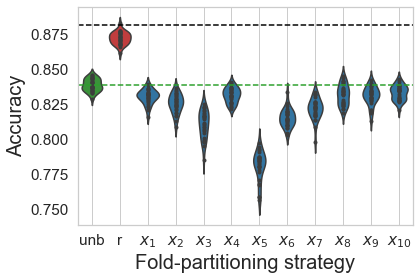

In [13]:
# Number of simulations
num_sim = 30

# Number of duplicates
num_dup = 2000

# Result array
results = []

# Results color
palette = []
palette.append('tab:green')
palette.append('tab:red')
for id_cov in range(10):
    palette.append('tab:blue')
        
av_unbiased = 0.0
for ind_sim in range(num_sim):
    print("Num sim: {}".format(ind_sim))
    
    # Raw data generation
    x_arr, y_arr, h_arr = raw_data_generator(param_data)
    
    # Data analysis without duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    param_data['num_dup'] = 0
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
    final_acc = 0.0
    for id_f in range(num_f):
        final_acc += val_acc[id_f][-1]
    final_acc /= num_f
    results.append([final_acc, 'unbiased'])
    av_unbiased += final_acc
    
    # Insertion of duplicates
    param_data['num_dup'] = num_dup
    x_arr, y_arr, h_arr = duplicates_generator(param_data, x_arr, y_arr, h_arr)
    
    # Data analysis with duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
    final_acc = 0.0
    for id_f in range(num_f):
        final_acc += val_acc[id_f][-1]
    final_acc /= num_f
    results.append([final_acc, 'rand'])
    
    split_strat = 'stratified'
    param_split['split_strat'] = split_strat
    
    for strat_cov_id in range(10):
        param_split['stratifying_covariate_id'] = strat_cov_id
        f_arr = stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr)
        train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
        final_acc = 0.0
        for id_f in range(num_f):
            final_acc += val_acc[id_f][-1]
        final_acc /= num_f
        results.append([final_acc, strat_cov_id+1])
    
sns.set(style="whitegrid", font_scale = 1.4)

fig, ax = plt.subplots()

dataFrame = pd.DataFrame(results, columns=['Accuracy','Fold-partitioning strategy'])
sns_plot = sns.violinplot(x='Fold-partitioning strategy', y='Accuracy', data=dataFrame, \
                          palette=palette, order=['unbiased', 'rand',1,2,3,4,5,6,7,8,9,10] \
                          ,inner="points", ax=ax)
sns_plot.set(xticklabels=['unb','r', r'$x_1$',r'$x_2$', r'$x_3$',r'$x_4$',r'$x_5$'\
                          ,r'$x_6$',r'$x_7$', r'$x_8$',r'$x_9$',r'$x_{10}$'])
sns_plot.set_xlabel('Fold-partitioning strategy', fontsize=20)
sns_plot.set_ylabel(r'Accuracy', fontsize=20)
ax.yaxis.grid(False)
ax.xaxis.grid(True)

fig = sns_plot.get_figure()
plt.axhline(y=acc_opt, ls='--', color ='black')

av_unbiased /= num_sim
plt.axhline(y=av_unbiased, ls='--', color ='tab:green')

plt.show()

fig.savefig('Fig3.pdf', bbox_inches="tight")

## Comparison with logistic regresson and SVM modelings
In order to assess the relevance of gradient boosting modeling, we compute the accuracies obtained by logistic regression and SVM applied to the same dataset.

#### Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
# Number of simulations
num_sim = 30

# Result array    
acc_list = []
for ind_sim in range(num_sim):
    print("Num sim: {}".format(ind_sim))

    # Data analysis without duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    param_data['num_dup'] = 0
    
    # Raw data generation
    x_arr, y_arr, h_arr = raw_data_generator(param_data)
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    
    
    for id_f in range(num_f):
        x_train, y_train, x_val, y_val = train_val_building(param_data, param_split, x_arr, y_arr, f_arr, id_f)
        
        clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='none').fit(x_train, y_train)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = np.mean(y_pred * y_val+(1-y_pred) * (1-y_val))
        acc_list.append(acc)

print("Logistic regression mean accuracy: {}".format(np.mean(acc_list)))

Num sim: 0
Num sim: 1
Num sim: 2
Num sim: 3
Num sim: 4
Num sim: 5
Num sim: 6
Num sim: 7
Num sim: 8
Num sim: 9
Num sim: 10
Num sim: 11
Num sim: 12
Num sim: 13
Num sim: 14
Num sim: 15
Num sim: 16
Num sim: 17
Num sim: 18
Num sim: 19
Num sim: 20
Num sim: 21
Num sim: 22
Num sim: 23
Num sim: 24
Num sim: 25
Num sim: 26
Num sim: 27
Num sim: 28
Num sim: 29
Logistic regression mean accuracy: 0.7362934248566351


#### SVM

In [15]:
from sklearn import svm

# Number of simulations
num_sim = 30

# Result array
acc_list = []
for ind_sim in range(num_sim):
    print("Num sim: {}".format(ind_sim))
    
    # Data analysis without duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    param_data['num_dup'] = 0
    
    
    #Raw data generation
    x_arr, y_arr, h_arr = raw_data_generator(param_data)
    
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    
    
    for id_f in range(num_f):
        x_train, y_train, x_val, y_val = train_val_building(param_data, param_split, x_arr, y_arr, f_arr, id_f)
        
        clf = svm.SVC(gamma='auto')
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = np.mean(y_pred * y_val+(1-y_pred) * (1-y_val))
        acc_list.append(acc)
print("SVM mean accuracy: {}".format(np.mean(acc_list)))

Num sim: 0
Num sim: 1
Num sim: 2
Num sim: 3
Num sim: 4
Num sim: 5
Num sim: 6
Num sim: 7
Num sim: 8
Num sim: 9
Num sim: 10
Num sim: 11
Num sim: 12
Num sim: 13
Num sim: 14
Num sim: 15
Num sim: 16
Num sim: 17
Num sim: 18
Num sim: 19
Num sim: 20
Num sim: 21
Num sim: 22
Num sim: 23
Num sim: 24
Num sim: 25
Num sim: 26
Num sim: 27
Num sim: 28
Num sim: 29
SVM mean accuracy: 0.8186232335443757


### Fig. 4: Correlation of the pessimistic bias and the importance of the stratifying covariate
We run simulations to quantify the association between the pessimistic bias and the importance of the stratifying covariate $x_{str}$.

We draw 100 random sets of generating parameters $\{\Sigma, \mathbf{a}\}$. For each set $\{\Sigma, \mathbf{a}\}$ we generate a dataset without duplicates and we fit a gradient boosting on it using classical cross-validation, measuring thus an unbiased estimate of accuracy. We compute the feature importances of each covariate, and we normalize them by the maximum feature importance in order to obtain values between 0 and 1 (see [1] p.367 for computational details). 

We then add duplicates to each dataset, and analyze it through *stratified cross-validation* using successively each one of the 10 covariates as the stratifying covariate. We plot the ratio of accuracy measured after having stratified along $x_{str}$ over the unbiased estimate of accuracy, as a function of the normalized feature importance of the stratifying covariate.

[1] Trevor Hastie, Robert Tibshirani, and Jerome Friedman. The Elements of Statistical Learning: Data Mining,
Inference, and Prediction, Second Edition. Springer Series in Statistics. Springer-Verlag, New York, 2 edition,
2009.

A_vec number: 0
A_vec number: 1
A_vec number: 2
A_vec number: 3
A_vec number: 4
A_vec number: 5
A_vec number: 6
A_vec number: 7
A_vec number: 8
A_vec number: 9
A_vec number: 10
A_vec number: 11
A_vec number: 12
A_vec number: 13
A_vec number: 14
A_vec number: 15
A_vec number: 16
A_vec number: 17
A_vec number: 18
A_vec number: 19
A_vec number: 20
A_vec number: 21
A_vec number: 22
A_vec number: 23
A_vec number: 24
A_vec number: 25
A_vec number: 26
A_vec number: 27
A_vec number: 28
A_vec number: 29
A_vec number: 30
A_vec number: 31
A_vec number: 32
A_vec number: 33
A_vec number: 34
A_vec number: 35
A_vec number: 36
A_vec number: 37
A_vec number: 38
A_vec number: 39
A_vec number: 40
A_vec number: 41
A_vec number: 42
A_vec number: 43
A_vec number: 44
A_vec number: 45
A_vec number: 46
A_vec number: 47
A_vec number: 48
A_vec number: 49
A_vec number: 50
A_vec number: 51
A_vec number: 52
A_vec number: 53
A_vec number: 54
A_vec number: 55
A_vec number: 56
A_vec number: 57
A_vec number: 58
A_vec n

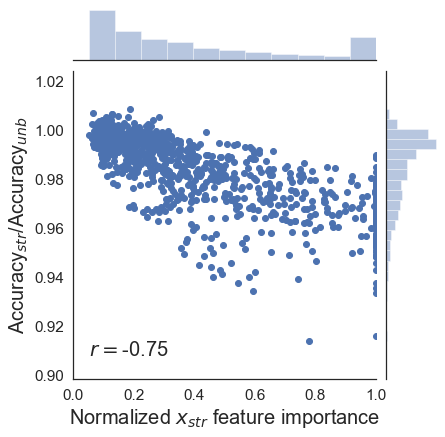

In [16]:
# Number of a_vec that are tested
num_a_vec = 100

# Results list
results = []

for id_a_vec in range(num_a_vec):
    print("A_vec number: {}".format(id_a_vec))
    av_feat_imp = np.zeros(10)
    av_val_acc = np.zeros(10)
    
    ### Weights of generating law
    a_vec = 10.0*(np.random.rand(8)-0.5*np.ones(8))
    ### Eigenvalues of the covariance matrix
    lambda_vec = 2.0*np.random.rand(9)+np.ones(9)
    lambda_10 = 2.0*np.random.rand() + 1.0
    ### Random orthogonal matrix
    O = scipy.stats.ortho_group.rvs(9)
    ### Covariance matrix
    sigma_prime = np.dot(O, np.dot(np.diag(lambda_vec), np.transpose(O)))
    sigma = scipy.linalg.block_diag(sigma_prime, lambda_10)

    param_data['a_vec'] = a_vec
    param_data['sigma'] = sigma
    
    # Raw data generation
    x_arr, y_arr, h_arr = raw_data_generator(param_data)

    # Data analysis without duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    param_data['num_dup'] = 0
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
    unbiased_val_acc = 0.0
    feat_norm = np.zeros(10)
    for id_f in range(num_f):
        unbiased_val_acc += val_acc[id_f][-1]
    for id_cov in range(10):
        key = 'f'+str(id_cov)
        for id_f in range(num_f):
            feat_norm[id_cov] += feat_imp[id_f][key]
    unbiased_val_acc /= num_f
    feat_norm /= np.amax(feat_norm)
    
    # Insertion of duplicates
    param_data['num_dup'] = 2000
    x_arr, y_arr, h_arr = duplicates_generator(param_data, x_arr, y_arr, h_arr)
    
    param_split['split_strat'] = 'stratified'
    for strat_cov_id in range(10):
        param_split['stratifying_covariate_id'] = strat_cov_id
        
        # Splitting of datasets in folds
        f_arr = stratified_splitting(param_data, param_split, x_arr, y_arr, h_arr)

        train_acc, val_acc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
        final_acc = 0.0
        for id_f in range(num_f):
            final_acc += val_acc[id_f][-1]
        final_acc /= num_f
        final_acc /= unbiased_val_acc
        results.append([feat_norm[strat_cov_id], final_acc])
        
results = np.asarray(results)
np.savetxt("feature_importance.csv", results)
corr = np.corrcoef(np.asarray(results).T)
print("Pearson product-moment correlation coefficients: {}".format(corr))

sns.set(style="white",font_scale = 1.4)
sns_plot2 = sns.jointplot(results[:,0], results[:,1], xlim=(0,1))
sns_plot2.set_axis_labels(r'Normalized $x_{str}$ feature importance', r'Accuracy$_{str}$/Accuracy$_{unb}$', fontsize=20)
sns_plot2.fig.text(0.15,0.15,"$r=${}".format(round(corr[0][1], 2)), fontsize=20)

sns_plot2.savefig('Fig4.pdf', bbox_inches="tight")

# Real medical data: MIMIC-III dataset
In order to complement the study of stratified cross-validation that has been conducted on synthetic datasets, we consider now the case of real medical data. We focus on the famous MIMIC-III dataset that is freely available for research [2]. We have extracted from the database a set of 31384 records corresponding to the admissions of patients in two different intensive care units (ICU), either the medical one (MICU) or the surgical one (SICU). Each record corresponds to a single admission, and a patient may have multiple admissions. For the sake of simplicity and to avoid data leakage between various records related to a given patient, we keep at random only one record per patient. For each record, we have computed the 15 explanatory variables used in SOFA score [3] and we keep 4 additional variables that are used for stratification: age at admission, weight at admission, lowest creatinine value from the first 24 hours after ICU admission, lowest blood urea nitrogen value from the first 24 hours after ICU admission, highest hemoglobin value from the first 24 hours after ICU admission. These variables may vary from one admission to another for a the same patient, but they are shared by duplicated records. 

To mimick the duplication of records that may occur when a patient is transferred from one ICU to the other, we duplicate at random 17% of each ICU records, and transfer them to the other ICU. We reproduce the training and validation of a mortality prediction model using gradient boosting [4], and compare the measured performances either 1) in absence of duplication or 2) with duplication and random cross-validation or 3) with duplication and stratified cross-validation.

The part of this notebook that is related to real medical records is not run for privacy protection. 

[2] Johnson AEW, Pollard TJ, Shen L, et al. MIMIC-III, a freely accessible critical care database. Sci Data 2016;3:1–9. doi:10.1038/sdata.2016.35

[3] Vincent JL, Moreno R, Takala J, et al. The SOFA (Sepsis-related Organ Failure Assessment) score to describe organ dysfunction/failure. On behalf of the Working Group on Sepsis-Related Problems of the European Society of Intensive Care Medicine. Intensive Care Med 1996;22:707–10. doi:10.1007/bf01709751

[4] Pirracchio R, Petersen ML, Carone M, et al. Mortality prediction in intensive care units with the Super ICU Learner Algorithm (SICULA): a population-based study. Lancet Respir Med 2015;3:42–52. doi:10.1016/S2213-2600(14)70239-5

## Dataset pre-processing
We upload a csv file containing all the records related to the two ICUs of interest (n=31384). For each record we have the 15 explanatory variables of SOFA score and the 5 stratifying covariates. When one explanatory variable was missing, a value of 0 has been imputed.

In [ ]:
# Upload of a pre-processed csv file with variables of interest
df_mimic = pd.read_csv("cleaned_mimic_4.csv")
df_mimic = df_mimic.drop('Unnamed: 0', axis=1)
df_mimic.head()


In [ ]:
df_mimic.shape

# RESULT:

# (31384, 28)

In [ ]:
# Replacing string variables by integers
df_mimic = df_mimic.replace({'CURR_CAREUNIT_transfers' : 'MICU'}, 0)
df_mimic = df_mimic.replace({'CURR_CAREUNIT_transfers' : 'SICU'}, 1)
df_mimic = df_mimic.replace({'gender' : 'M'}, 0)
df_mimic = df_mimic.replace({'gender' : 'F'}, 1)

In [ ]:
# Computation of the rate of missing value for stratifying covariates (imputation of 0 for saps-ii scores already done)
num_rec, _ = df_mimic.shape
100*df_mimic.isnull().sum()/num_rec

# RESULT:

# columns:hadm_id                     0.000000
# subject_id                  0.000000
# sapsii                      0.000000
# sapsii_prob                 0.000000
# age_score                   0.000000
# hr_score                    0.000000
# sysbp_score                 0.000000
# temp_score                  0.000000
# pao2fio2_score              0.000000
# uo_score                    0.000000
# bun_score                   0.000000
# wbc_score                   0.000000
# potassium_score             0.000000
# sodium_score                0.000000
# bicarbonate_score           0.000000
# bilirubin_score             0.000000
# gcs_score                   0.000000
# comorbidity_score           0.000000
# admissiontype_score         0.000000
# hospital_mortality          0.000000
# gender                      0.000000
# age                         0.000000
# creatinine_min              1.516696
# CURR_CAREUNIT_transfers     0.000000
# weight                     12.719857
# bun_min                     1.523069
# hemoglobin_max              1.746113
# height                     40.992225

In [ ]:
# Imputation of 0 in place of missing values
df_mimic = df_mimic.fillna(0)

In [ ]:
# Keeping at random one record for each individual
df_mimic_1rec = df_mimic.groupby('subject_id').apply(lambda df: df.sample(1))

# Total number of records
num_tot_rec = df_mimic_1rec.shape[0]
print("Total number of records in the deduplicated dataset: {}".format(num_tot_rec))

# Number of records in medical ICU
num_MICU_rec = df_mimic_1rec[df_mimic_1rec['CURR_CAREUNIT_transfers']==0].shape[0]
print("MICU number of records in the deduplicated dataset: {}".format(num_MICU_rec))

# Number of records in surgical ICU
num_SICU_rec = df_mimic_1rec[df_mimic_1rec['CURR_CAREUNIT_transfers']==1].shape[0]
print("SICU number of records in the deduplicated dataset: {}".format(num_SICU_rec))

# RESULT:
# Total number of records in the deduplicated dataset: 22678
# MICU number of records in the deduplicated dataset: 15446
# SICU number of records in the deduplicated dataset: 7232


In [ ]:
# Definition of various dataframes
## Training covariates dataframe
df_mimic_x = df_mimic_1rec[['age_score','hr_score','sysbp_score','temp_score', \
                            'pao2fio2_score','uo_score','bun_score','wbc_score', \
                            'potassium_score','sodium_score','bicarbonate_score', \
                            'bilirubin_score','gcs_score','comorbidity_score', \
                            'admissiontype_score']]

## Outcome dataframe
df_mimic_y = df_mimic_1rec[['hospital_mortality']]

## ICU dataframe
df_mimic_h = df_mimic_1rec[['CURR_CAREUNIT_transfers']]

## Stratifying covariates dataframe
df_mimic_strat_cov = df_mimic_1rec[['age', 'weight','creatinine_min', 'bun_min','hemoglobin_max']]

In [ ]:
# Converting dataframes to numpy arrays
x_arr_0 = df_mimic_x.to_numpy()
y_arr_0 = np.squeeze(df_mimic_y.to_numpy())
h_arr_0 = np.squeeze(df_mimic_h.to_numpy())
strat_arr_0 = df_mimic_strat_cov.to_numpy()

# Training and validation of a mortality prediction model
We train and validate a gradient boosting model on the n=22678 records either directly or after having added 17% duplicates.

### Fig: training and validation monitoring

In [ ]:
# Number of patients
num_pat = x_arr_0.shape[0]
param_data['num_pat'] = num_pat

# Number of hospitals (corresponding here to the two ICUs)
num_h = 2
param_data['num_h'] = num_h

## Model definition
fit_model = 'GB'
max_depth = 3
eta = 0.6
objective = 'binary:logistic'
eval_metric = 'auc'
num_round = 200
param_model = {'fit_model':fit_model, 'max_depth':max_depth, 'eta':eta, 'objective':objective, 'eval_metric':eval_metric, 
              'num_round':num_round}

# Print proportion of positive outcome
prop_outcome = np.sum(y_arr_0)/len(y_arr_0)
prop_outcome_MICU = np.sum(y_arr_0[h_arr_0==0])/len(y_arr_0[h_arr_0==0])
prop_outcome_SICU = np.sum(y_arr_0[h_arr_0==1])/len(y_arr_0[h_arr_0==1])
print("Proportion of positive outcome ICU: {}".format(prop_outcome))
print("Proportion of positive outcome MICU: {}".format(prop_outcome_MICU))
print("Proportion of positive outcome SICU: {}".format(prop_outcome_SICU))

# Definition of working arrays
x_arr, y_arr, h_arr = np.copy(x_arr_0), np.copy(y_arr_0), np.copy(h_arr_0)

# ANALYSIS 1: without duplicates (unbiased), with classical cross-validation
# Number of duplicates
num_dup = 0
param_data['num_dup'] = num_dup
split_strat = 'random'
param_split['split_strat'] = split_strat
f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)

# Number of training curves (correspond to each training on a subset during cross-validation)
num_curve = len(train_auc)
num_feat_importance = len(feat_imp)
epochs = len(train_auc[0])
x_plt = np.linspace(0, epochs, epochs)

av_train_unbias_auc = np.zeros(epochs)
av_train_r_auc = np.zeros(epochs)
av_train_x_auc = np.zeros(epochs)

av_val_unbias_auc = np.zeros(epochs)
av_val_r_auc = np.zeros(epochs)
av_val_x_auc = np.zeros(epochs)

for id_curve in range(num_curve):
    av_train_unbias_auc += train_auc[id_curve]
    av_val_unbias_auc += val_auc[id_curve]

# ANALYSIS 2: with duplicates
# Insertion of duplicates
num_dup = int(np.floor(x_arr_0.shape[0])*0.17/(1-0.17))
param_data['num_dup'] = num_dup
print("Number of duplicates added : {}".format(num_dup))
l_x = x_arr_0.shape[1]
x_strat_arr_0 = np.concatenate((x_arr_0, strat_arr_0), axis=1)
x_strat_arr, y_arr, h_arr = duplicates_generator(param_data, x_strat_arr_0, y_arr_0, h_arr_0)
x_arr, strat_arr = np.split(x_strat_arr, [l_x], axis=1)

# Analysis through random fold-partitioning
split_strat = 'random'
param_split['split_strat'] = split_strat
f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
for id_curve in range(num_curve):
    for id_epoch in range(epochs):
        av_train_r_auc[id_epoch] += train_auc[id_curve][id_epoch]
        av_val_r_auc[id_epoch] += val_auc[id_curve][id_epoch]

# Analysis through stratified fold-partitioning
split_strat = 'stratified'
param_split['split_strat'] = split_strat
stratifying_covariate_id = 0
param_split['stratifying_covariate_id'] = stratifying_covariate_id
f_arr = stratified_splitting(param_data, param_split, strat_arr, y_arr, h_arr)
train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
for id_curve in range(num_curve):
    av_train_x_auc += train_auc[id_curve]
    av_val_x_auc += val_auc[id_curve]
        
av_train_unbias_auc /= num_curve  
av_train_r_auc /= num_curve
av_train_x_auc /= num_curve

av_val_unbias_auc /= num_curve
av_val_r_auc /= num_curve
av_val_x_auc /= num_curve

# Plot training and validation curves
x_unbias_m = [x_plt[index] for index in range(len(x_plt)) if (index+16)%24==0]
train_unbias_m = [av_train_unbias_auc[index] for index in range(len(x_plt)) if (index+16)%24==0]
x_r_m = [x_plt[index] for index in range(len(x_plt)) if index%24==0]
train_r_m = [av_train_r_auc[index] for index in range(len(x_plt)) if index%24==0]
x_x_m = [x_plt[index] for index in range(len(x_plt)) if (index+8)%24==0]
train_x_m = [av_train_x_auc[index] for index in range(len(x_plt)) if (index+8)%24==0]


fig, ax = plt.subplots()
sns.set(style="white", font_scale = 1.4)

s1 = plt.scatter(x_unbias_m, train_unbias_m, label=r'train unb', color='tab:green', marker='s', s=50)
s2 = plt.scatter(x_r_m, train_r_m, label=r'train rand', color='tab:red', marker='o', s=50)
s3 = plt.scatter(x_x_m, train_x_m, label=r'train age-str', color='tab:blue', marker='^', s=50)

p1 = plt.plot(x_plt, av_val_unbias_auc, label=r'val unb', color='tab:green', ls='-.', lw =3)
p2 = plt.plot(x_plt, av_val_r_auc, label='val rand', color='tab:red', ls='-', lw =3)
p3 = plt.plot(x_plt, av_val_x_auc, label=r'val age-str', color='tab:blue', ls='--', lw =3)

plt.xlabel("Boosting iterations", fontsize = 20)
plt.ylabel(r"AUC", fontsize = 20)

plt.ylim(0.80,0.9)
plt.xlim(0,200)
l1 = plt.legend(loc = 2, handlelength=4, fontsize=10)

plt.savefig('Fig_Monitoring_MIMIC.pdf', bbox_inches="tight")

# RESULT:

# Proportion of positive outcome: 0.16293323926272157
# Number of duplicates added : 4644


### Fig. Correlation of the pessimistic bias and the importance of the stratifying covariate

In [ ]:
#Number of simulations
num_sim = 30

# Number of duplicates
num_dup = int(np.floor(x_arr_0.shape[0])*0.17/(1-0.17))
print("Number of duplicates added : {}".format(num_dup))

# Result array
results = []

# Results color
palette = []
palette.append('tab:green')
palette.append('tab:red')
for id_cov in range(5):
    palette.append('tab:blue')
        
for ind_sim in range(num_sim):
    print("Num sim: {}".format(ind_sim))
    
    # Raw data generation
    x_arr, y_arr, h_arr, strat_arr = x_arr_0, y_arr_0, h_arr_0, strat_arr_0
    
    # Data analysis without duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    param_data['num_dup'] = 0
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
    final_auc = 0.0
    for id_f in range(num_f):
        final_auc += val_auc[id_f][-1]
    final_auc /= num_f
    results.append([final_auc, 'unbiased', 'NaN'])
    
    # Data analysis without duplicates with all variables, including stratifying covariates, 
    # to measure covariate importance
    x_arr_1 = np.concatenate((x_arr, strat_arr), axis=1)
    f_arr = random_splitting(param_data, param_split, x_arr_1, y_arr, h_arr)
    num_f = param_split['num_f']
    train_auc, val_auc, feat_imp = GB_fitting(x_arr_1, y_arr, f_arr, param_data, param_split, param_model)
    feat_norm = np.zeros(x_arr_1.shape[1])
    for id_cov in range(x_arr_1.shape[1]):
        key = 'f'+str(id_cov)
        for id_f in range(num_f):
            if key in feat_imp[id_f]:
                feat_norm[id_cov] += feat_imp[id_f][key]
    feat_norm /= np.amax(feat_norm)
    
    # Insertion of duplicates
    param_data['num_dup'] = num_dup
    
    l_x = x_arr_0.shape[1]
    x_strat_arr_0 = np.concatenate((x_arr_0, strat_arr_0), axis=1)
    x_strat_arr, y_arr, h_arr = duplicates_generator(param_data, x_strat_arr_0, y_arr_0, h_arr_0)
    x_arr, strat_arr = np.split(x_strat_arr, [l_x], axis=1)
    
    # Data analysis with duplicates
    split_strat = 'random'
    param_split['split_strat'] = split_strat
    f_arr = random_splitting(param_data, param_split, x_arr, y_arr, h_arr)
    num_f = param_split['num_f']
    train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
    final_auc = 0.0
    for id_f in range(num_f):
        final_auc += val_auc[id_f][-1]
    final_auc /= num_f
    results.append([final_auc, 'rand', 'NaN'])
    
    split_strat = 'stratified'
    param_split['split_strat'] = split_strat
    
    for strat_cov_id in range(5):
        param_split['stratifying_covariate_id'] = strat_cov_id
        f_arr = stratified_splitting(param_data, param_split, strat_arr, y_arr, h_arr)
        train_auc, val_auc, feat_imp = GB_fitting(x_arr, y_arr, f_arr, param_data, param_split, param_model)
        final_auc = 0.0
        for id_f in range(num_f):
            final_auc += val_auc[id_f][-1]
        final_auc /= num_f
        results.append([final_auc, strat_cov_id+1, feat_norm[x_arr.shape[1]+strat_cov_id]])
    
sns.set(style="whitegrid", font_scale = 1.4)

fig, ax = plt.subplots()

dataFrame = pd.DataFrame(results, columns=['AUC','Fold-partitioning strategy','Feature importance'])
sns_plot = sns.violinplot(x='Fold-partitioning strategy', y='AUC', data=dataFrame, \
                          palette=palette, order=['unbiased', 'rand',1,2,3,4,5] \
                          ,inner="points", ax=ax)
sns_plot.set(xticklabels=['unb','r', r'age',r'wei', r'cre', r'bun', r'hem'])
sns_plot.set_xlabel('Fold-partitioning strategy', fontsize=20)
sns_plot.set_ylabel(r'AUC', fontsize=20)
ax.set_ylim(0.79, 0.89)
ax.yaxis.grid(False)
ax.xaxis.grid(True)


list_foldpart_strat = ['unbiased', 'rand',1,2,3,4,5]

av_unbiased = 0
for item in list_foldpart_strat:
    av_auc = dataFrame[dataFrame['Fold-partitioning strategy']==item].mean(axis=0)['AUC']
    print("Mean AUC for {} strategy: {}".format(item, av_auc))
    if item=='unbiased':
        av_unbiased = av_auc
plt.axhline(y=av_unbiased, ls='--', color ='tab:green')



axins = inset_axes(ax,  "40%", "40%" ,loc="upper right", borderpad=0)
dataFrame = dataFrame[(dataFrame['Fold-partitioning strategy']!='unbiased')&(dataFrame['Fold-partitioning strategy']!='rand')]
dataFrame['AUC'] = dataFrame['AUC']/av_unbiased
sns_subplot = sns.scatterplot(x='Feature importance', y='AUC', data=dataFrame)
sns_subplot.set_xlabel('Norm. feat. imp.', fontsize=15)
sns_subplot.set_ylabel(r'AUC/AUC$_{unb}$', fontsize=15)



results = dataFrame[['AUC', 'Feature importance']].to_numpy()
corr = np.corrcoef(results.astype(float).T)
print("Pearson product-moment correlation coefficients: {}".format(corr))
sns_subplot.text(0.15,0.95,"$r=${}".format(round(corr[0][1], 2)), fontsize=15)

sns_subplot.figure.savefig('Fig5.pdf', bbox_inches="tight")